In [8]:
from qiskit.visualization import plot_histogram
from qiskit import Aer, QuantumCircuit, execute, QuantumRegister, ClassicalRegister
import numpy as np

In [9]:
def diffuser(nqubits):
    qc = QuantumCircuit(nqubits)
    # Apply transformation |s> -> |00..0> (H-gates)
    for qubit in range(nqubits):
        qc.h(qubit)
    # Apply transformation |00..0> -> |11..1> (X-gates)
    for qubit in range(nqubits):
        qc.x(qubit)
    # Do multi-controlled-Z gate
    qc.h(nqubits-1)
    qc.mct(list(range(nqubits-1)), nqubits-1)  # multi-controlled-toffoli
    qc.h(nqubits-1)
    # Apply transformation |11..1> -> |00..0>
    for qubit in range(nqubits):
        qc.x(qubit)
    # Apply transformation |00..0> -> |s>
    for qubit in range(nqubits):
        qc.h(qubit)
    # We will return the diffuser as a gate
    U_s = qc.to_gate()
    U_s.name = "U$_s$"
    return U_s

In [10]:
def xor(qc, a, b, output):
    qc.cx(a, output)
    qc.cx(b, output)

In [11]:
clause_list = [[0, 4],
               [0, 8],
               [1, 5],
               [1, 9],
               [2, 6],
               [2, 10],
               [3, 7],
               [3, 11],
               [4, 12],
               [5, 13],
               [6, 14],
               [7, 15]]

In [12]:
def sudoku_oracle(qc, clause_list, clause_qubits, output_qubit):
    # Use XOR gate to check each clause
    i = 0
    for clause in clause_list:
        xor(qc, clause[0], clause[1], clause_qubits[i])
        i += 1
    qc.mct(clause_qubits, output_qubit)
    # Uncompute clauses to reset clause-checking bits to 0
    i = 0
    for clause in clause_list:
        xor(qc, clause[0], clause[1], clause_qubits[i])
        i += 1

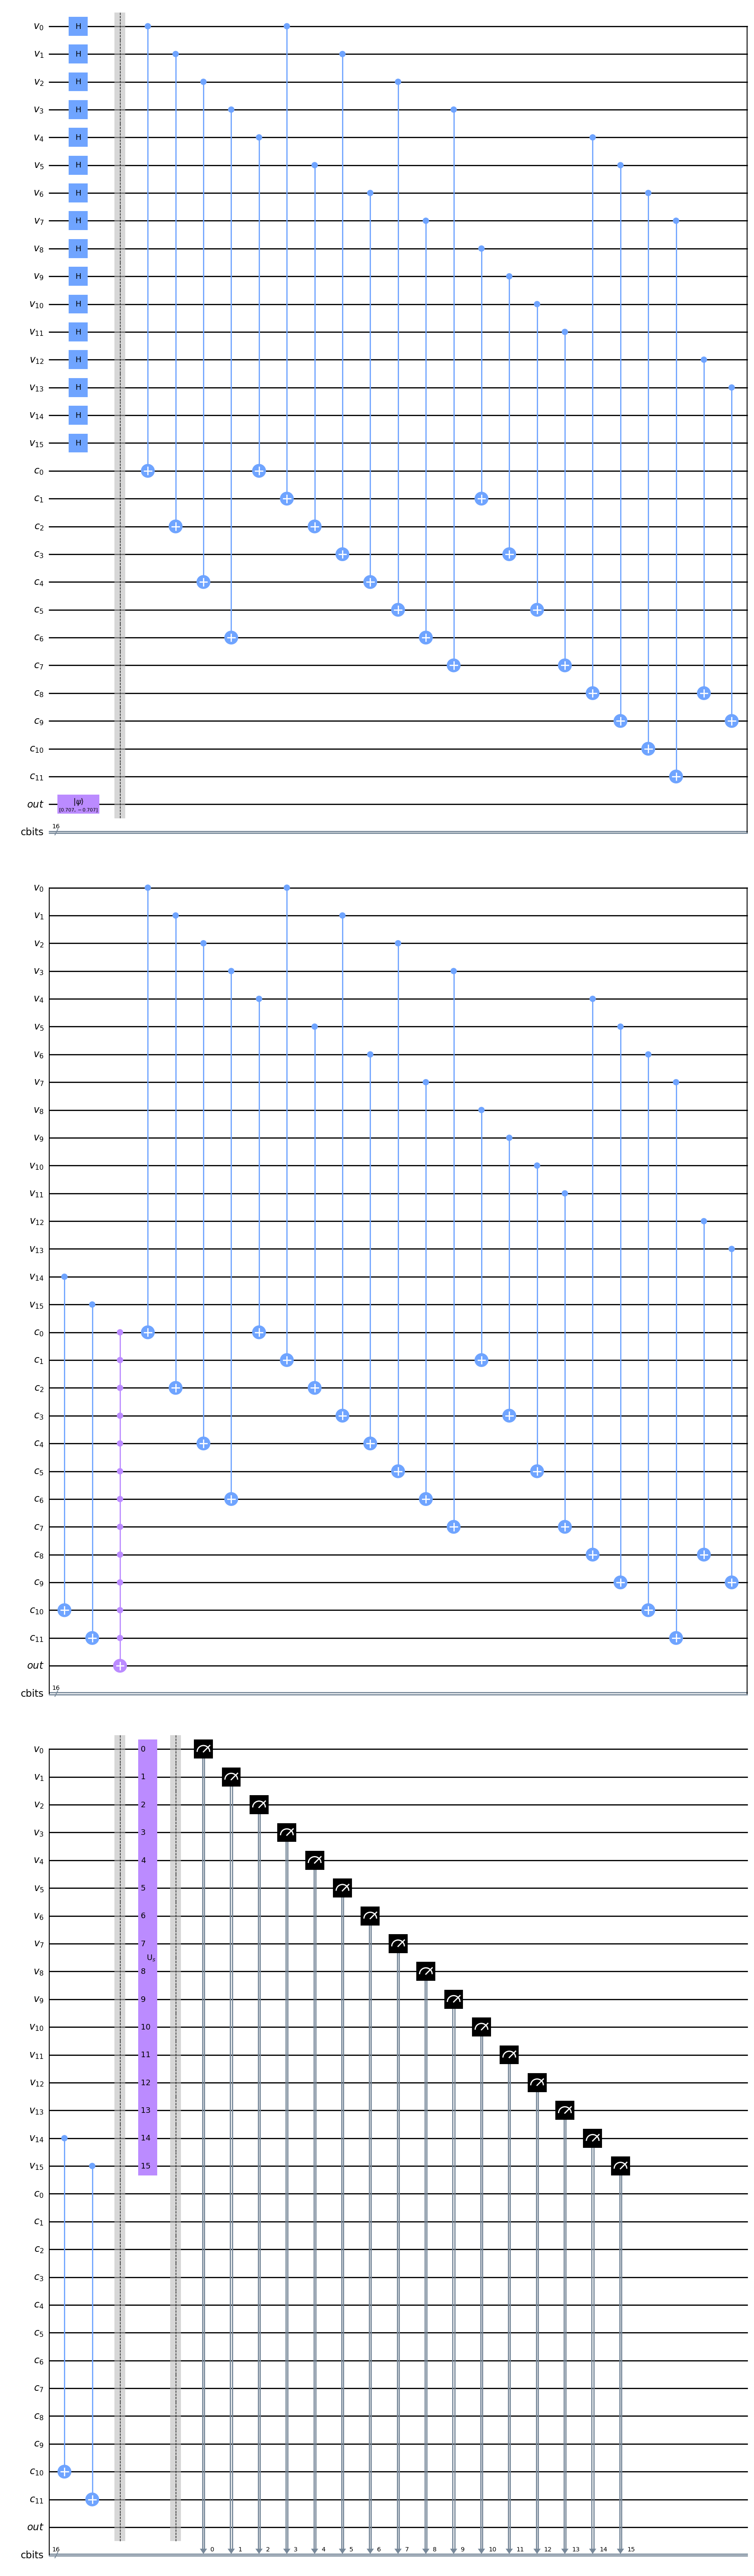

In [13]:
var_qubits = QuantumRegister(16, name='v')
clause_qubits = QuantumRegister(12, name='c')
output_qubit = QuantumRegister(1, name='out')
cbits = ClassicalRegister(16, name='cbits')
sudoku = QuantumCircuit(var_qubits, clause_qubits, output_qubit, cbits)

# Initialize 'out0' in state |->
sudoku.initialize([1, -1]/np.sqrt(2), output_qubit)

# Initialize qubits in state |s>
sudoku.h(var_qubits)
sudoku.barrier()  # for visual separation

for _ in range(1):
    sudoku_oracle(sudoku, clause_list, clause_qubits, output_qubit)
    sudoku.barrier()  # for visual separation
    # Apply our diffuser
    sudoku.append(diffuser(16), range(16))

sudoku.barrier()  # for visual separation
sudoku.measure(var_qubits, cbits)
sudoku.draw('mpl')

In [14]:
simulator = Aer.get_backend('aer_simulator')
results = execute(sudoku, backend=simulator, shots=10000).result()
counts = results.get_counts()
plot_histogram(counts)

Simulation failed and returned the following error message:
ERROR: a circuit requires more memory than max_memory_mb.


QiskitError: 'ERROR: a circuit requires more memory than max_memory_mb. ,  EMPTY'